In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
font={'size':18}
rc('font',**font)
from matplotlib.patches import Ellipse
from matplotlib.colors import BoundaryNorm,PowerNorm
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable
from pmagpy import pmag, ipmag

### Notebook for making Figures from the Paper
This notebook plots figures 1, 3 and 8 in the paper. `Pmagpy` is needed to plot these data along with libraries included with anaconda as standard.

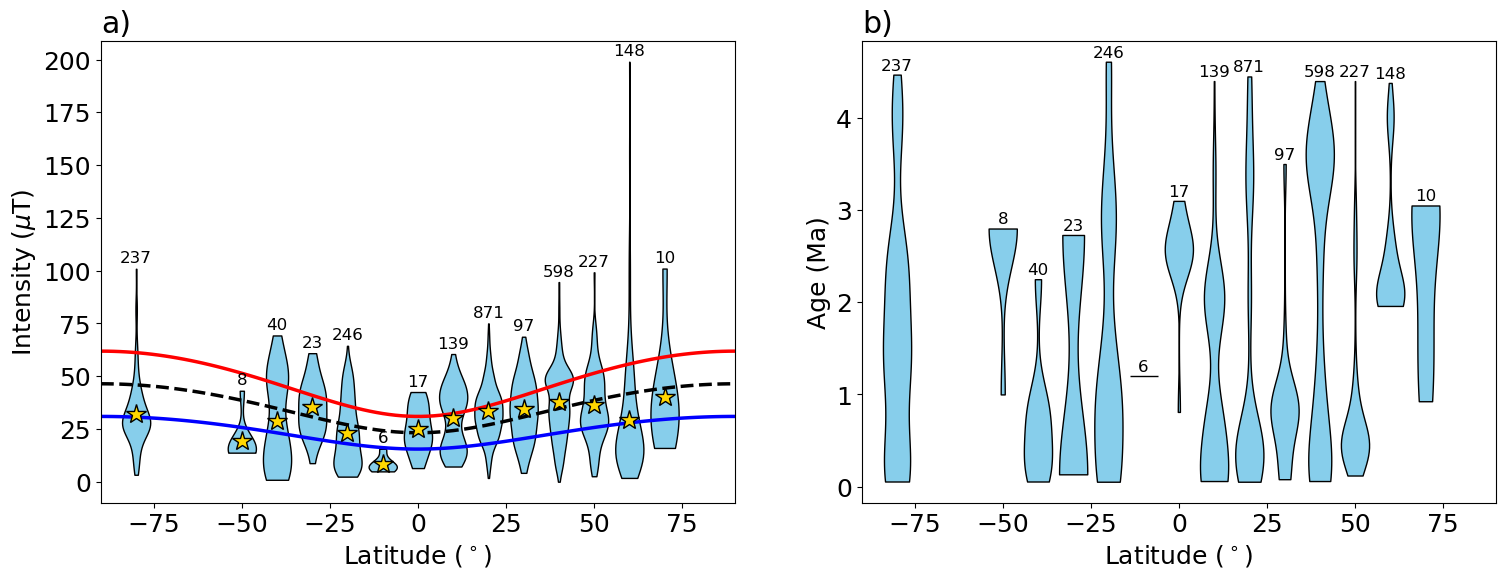

In [2]:
#Figure 1 - Current state of the MagIC database
fig,ax=plt.subplots(1,2,figsize=(18,6))

#Import data downloaded from MagIC
all_sites=pd.read_csv('Magic_Intensities/magic_downloaded_rows.txt',sep='\t',skiprows=5)
#Drop irrelevant data
all_sites.dropna(subset=['int_abs','age','lat'],inplace=True)

#Convert ages to consistent scale
all_sites.loc[all_sites.age_unit=='Years BP','age']/=1e6
all_sites.loc[all_sites.age_unit.str.lower()=='ka','age']/=1e3
#Remove data from 50ka to 5 Ma
all_sites=all_sites[(all_sites.age>0.05)&(all_sites.age<5)]




#Plot expected distributions of intensity with latitude
lats=np.linspace(-90,90,100)
ax[0].plot(np.linspace(-90,90,100),
           pmag.vdm_b(80*1e21,lats)*1e6,
           color='r',lw=2.5)
ax[0].plot(np.linspace(-90,90,100),
           pmag.vdm_b(60*1e21,lats)*1e6,
           color='k',lw=2.5,ls='--')
ax[0].plot(np.linspace(-90,90,100),
           pmag.vdm_b(40*1e21,lats)*1e6,
           color='b',lw=2.5)


all_sites['lat_bin']=-1000

#Sort data into latitude bins
for lat in np.linspace(-95,85,19):
    lat_bin=all_sites[(all_sites.lat>lat)&(all_sites.lat<lat+10)]
    ax[0].plot(lat+5,np.mean(lat_bin.int_abs)*1e6,'*',markerfacecolor='gold',markeredgecolor='k',markersize=15,zorder=10)
    
    if len(lat_bin)>0:
        ax[0].text(lat+5,np.amax(lat_bin.int_abs)*1e6+5,str(len(lat_bin)),ha='center',va='center',fontsize=12)
        ax[1].text(lat+5,np.amax(lat_bin.age)+0.1,str(len(lat_bin)),ha='center',va='center',fontsize=12)
    
    try:
        #Make violin plots of intensity and age
        ints=ax[0].violinplot(np.array([lat_bin.int_abs.values*1e6]).T,
                              positions=[lat+5],widths=[8],showmeans=False,
                              showmedians=False, showextrema=False)
        ages=ax[1].violinplot(np.array([lat_bin.age.values]).T,
                              positions=[lat+5],widths=[8],showmeans=False,
                              showmedians=False, showextrema=False)
        
        #Set colors for violin plots
        for age in ages['bodies']:
            age.set_facecolor('skyblue')
            age.set_edgecolor('black')
            age.set_alpha(1)
        for int_abs in ints['bodies']:
            int_abs.set_facecolor('skyblue')
            int_abs.set_edgecolor('black')
            int_abs.set_alpha(1)
            
    except:
        pass

#Set up limits and labels
ax[0].set_xlim(-90,90)
ax[1].set_xlim(-90,90)
ax[0].set_xlabel('Latitude ($^\circ$)');
ax[0].set_ylabel('Intensity ($\mu$T)');
ax[1].set_xlabel('Latitude ($^\circ$)');
ax[1].set_ylabel('Age (Ma)')
ax[0].set_title('a)',loc='left')
ax[1].set_title('b)',loc='left')
plt.savefig('Figures/Magic_Full_Database.pdf')

In [3]:
#Imports results from this study
sites=pd.read_csv('sites.txt',sep='\t',skiprows=1)
golan_sites=pd.read_csv('sites_golan.txt',sep='\t',skiprows=1) #Import data from Tauxe et al (2022) Golan Heights Study
HSDP2_sites=golan_sites[golan_sites.location=='HSDP2'] #Get HSDP2 core data reanalyzed from that study
sites=sites[sites.location=='Hawaiian Islands']
CCRIT_abs_pass=(sites.int_abs_sigma<=4e-6)
CCRIT_perc_pass=(sites.int_abs_sigma/sites.int_abs<=0.1)
BiCEP_abs_pass=(sites.int_abs_max-sites.int_abs_min<=1.6e-5)
BiCEP_perc_pass=((sites.int_abs_max-sites.int_abs_min)/sites.int_abs<=0.4)
passing=CCRIT_abs_pass|CCRIT_perc_pass|BiCEP_abs_pass|BiCEP_perc_pass
sites_passing=sites[passing]

#Sort results by analysis type
sites_BiCEP=sites_passing[sites_passing.method_codes.str.contains('IE-BICEP')]
sites_CCRIT=sites_passing[~sites_passing.method_codes.str.contains('IE-BICEP')]

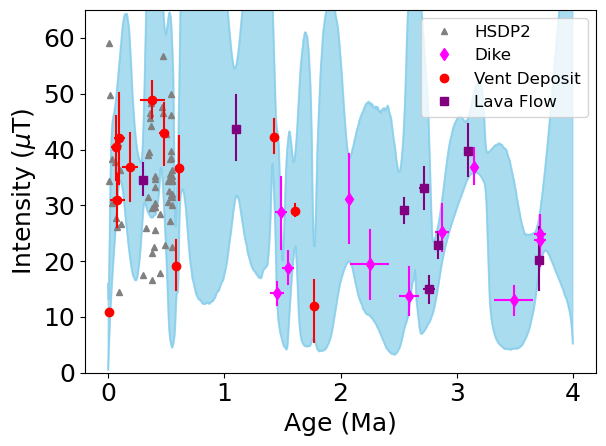

In [4]:
#Plots figure 3

#Sort results by lithology
BiCEP_dikes=sites_BiCEP[sites_BiCEP.geologic_classes.str.contains('Intrusive')];
BiCEP_cones=sites_BiCEP[sites_BiCEP.geologic_types.str.contains('Vent')];
BiCEP_flows=sites_BiCEP[sites_BiCEP.geologic_types.str.contains('Lava Flow')];

#Plot HSDP2 data
plt.plot(HSDP2_sites.age,HSDP2_sites.int_abs*1e6,'^',color='grey',zorder=-1,markersize=5,label='HSDP2')

#Plot HSDP2 data
plt.plot(BiCEP_dikes.age,BiCEP_dikes.int_abs*1e6,'d',color='fuchsia',label='Dike');
plt.plot(BiCEP_cones.age,BiCEP_cones.int_abs*1e6,'ro',label='Vent Deposit');
plt.plot(BiCEP_flows.age,BiCEP_flows.int_abs*1e6,'s',color='purple',label='Lava Flow')

#Plot x and y errors for vent deposits
plt.errorbar(BiCEP_cones['age'],BiCEP_cones['int_abs']*1e6,xerr=2*BiCEP_cones['age_sigma'],color='r',zorder=-1,linestyle='');
plt.plot([BiCEP_cones['age'].values,BiCEP_cones['age'].values],BiCEP_cones.loc[:,'int_abs_max':'int_abs_min'].values.T*1e6,color='r',zorder=0);

#Plot x and y errors for dikes
plt.errorbar(BiCEP_dikes['age'],BiCEP_dikes['int_abs']*1e6,xerr=2*BiCEP_dikes['age_sigma'],color='fuchsia',zorder=0,linestyle='');
plt.plot([BiCEP_dikes['age'].values,BiCEP_dikes['age'].values],BiCEP_dikes.loc[:,'int_abs_max':'int_abs_min'].values.T*1e6,color='fuchsia',zorder=0);

#Plot x and y errors for flows
plt.errorbar(BiCEP_flows['age'],BiCEP_flows['int_abs']*1e6,xerr=BiCEP_flows['age_sigma'],color='purple',zorder=-1,linestyle='');
plt.plot([BiCEP_flows['age'].values,BiCEP_flows['age'].values],BiCEP_flows.loc[:,'int_abs_max':'int_abs_min'].values.T*1e6,color='purple',zorder=0);

plt.ylabel('Intensity ($\mu$T)')
plt.xlabel('Age (Ma)');

#Plot bounds of AH-RJMCMC model
lowers=np.loadtxt('AH-RJMCMC1/Outputs/credible_lower.dat')
uppers=np.loadtxt('AH-RJMCMC1/Outputs/credible_upper.dat')
plt.fill_between(lowers[:,0]/1000,lowers[:,1],uppers[:,1],alpha=0.7,zorder=-2,color='skyblue')
plt.plot(lowers[:,0]/1000,lowers[:,1],color='skyblue',alpha=0.7,zorder=-2)
plt.plot(uppers[:,0]/1000,uppers[:,1],color='skyblue',alpha=0.7,zorder=-2);

#Set bounds and save to figure
plt.ylim(0,65);
plt.legend(fontsize=12);
plt.tight_layout()
plt.savefig('Figures/BiCEP_results.pdf')

In [6]:
def get_mean_VDMs(output_model,pltnum,lat,ax,color,max_date=2.5,min_date=0,location=None):
    """
    Gets a distribution of mean VADMs from the AH-RJMCMC model of
    Livermore et al (2018).
    
    Inputs
    ------
    output_model: list
    Output of AH-RJMCMC model, readinto python
    
    pltnum: int
    Determines x value of plot
    
    lat: float
    Average latitude of study
    
    ax: matplotlib axis
    Axis to plot violin plot
    
    color: str
    matplotlib color of violin plot
    
    max_date: float
    maximum date (in Ma) for average
    
    min_date: float
    minimum date (in Ma) for average
    
    Returns
    -------
    vdm_means: numpy array
    Distribution of mean VADMS.
    """
    
    #Sort of ages and model intensities
    discretise_size = int(output_model[0].split()[0])
    x_ages = [float(x) for x in output_model[1].split()]
    models = [float(x.split()[0]) for x in output_model[2:]]
    num_models =  int(len(models) / discretise_size)
    models = np.reshape(models,[num_models,discretise_size])
    
    #Only get things between age bounds
    models= models[:,(np.array(x_ages)<=max_date*1000)&(np.array(x_ages)>=min_date*1000)]
    
    #Convert to VADM space
    vdms=pmag.b_vdm(models*1e-6,lat)
    vdm_means=np.mean(vdms/1e21,axis=1)
    
    #Plot violin plot
    violin=ax.violinplot(vdm_means,positions=[pltnum],
                         widths=[1],showmeans=False, 
                         showmedians=False, showextrema=False);
    
    #Change violin color
    for age in violin['bodies']:
        age.set_facecolor(color)
        age.set_edgecolor('black')
        age.set_alpha(1)
        
    sites=pd.read_csv('sites.txt',sep='\t',skiprows=1)
    sites_location=sites[(sites.location==location)&(sites.age<=max_date)&(sites.age>=min_date)]
    sites_location=sites_location[sites_location.method_codes.str.contains('IE-BICEP')].dropna(subset=['age'])
    plt.text(pltnum,max(vdm_means)+5,str(len(sites_location)),va='center',ha='center',fontsize=12)
    return(vdm_means)

In [7]:
def plot_model_output(WD,fname,lat,ax,color,marker,max_date=2.5,**kwargs):
    """
    Plots bounds of model output from Livermore (2018)
    
    Inputs
    ------
    WD: string
    Working directory for model
    
    fname: string
    File name with model input data
    
    lat: float
    Average latitude of study
    
    ax: matplotlib axis
    Axis to plot model bounds
    
    color: str
    matplotlib color of data/model plot
    
    marker: str
    matplotlib marker code for data
    
    max_date: float
    maximum date (in Ma) for average
    
    Returns
    -------
    None
    """
    
    #Get lower and upper bounds of model
    lowers=np.loadtxt(WD+'/credible_lower.dat')
    uppers=np.loadtxt(WD+'/credible_upper.dat')
    
    #Convert ages and intensities to Ma/VADM
    model_ages=lowers[:,0]/1000
    model_Bs_lower=lowers[:,1]
    model_VADMs_lower=pmag.b_vdm(model_Bs_lower,lat)/1e27
    model_Bs_upper=uppers[:,1]
    model_VADMs_upper=pmag.b_vdm(model_Bs_upper,lat)/1e27
    
    #Only get things younger than the maximum date
    model_VADMs_lower=model_VADMs_lower[model_ages<max_date]
    model_VADMs_upper=model_VADMs_upper[model_ages<max_date]
    model_ages=model_ages[model_ages<max_date]
    
    #Open data file
    int_data=np.loadtxt(WD+'/'+fname,dtype='object')
    
    #Convert ages/intensities to Ma/VADM
    data_ages=int_data[:,1].astype(float)/1000
    data_ints=int_data[:,3].astype(float)
    data_VADMs=pmag.b_vdm(data_ints,lat)/1e27
    ax.axhline(np.mean(data_VADMs),color=color,linestyle='--')
    print(np.mean(data_VADMs))
    
    #Plot data and model results
    ax.fill_between(model_ages,model_VADMs_lower,model_VADMs_upper,color=color,alpha=0.1,zorder=-1)
    ax.plot(model_ages,model_VADMs_lower,color=color,zorder=0)
    ax.plot(model_ages,model_VADMs_upper,color=color,zorder=0)
    ax.plot(data_ages,data_VADMs,marker=marker,color=color,lw=0,**kwargs)

77.24044076426847
64.33244823488612
39.60527010009202
62.419444990760056


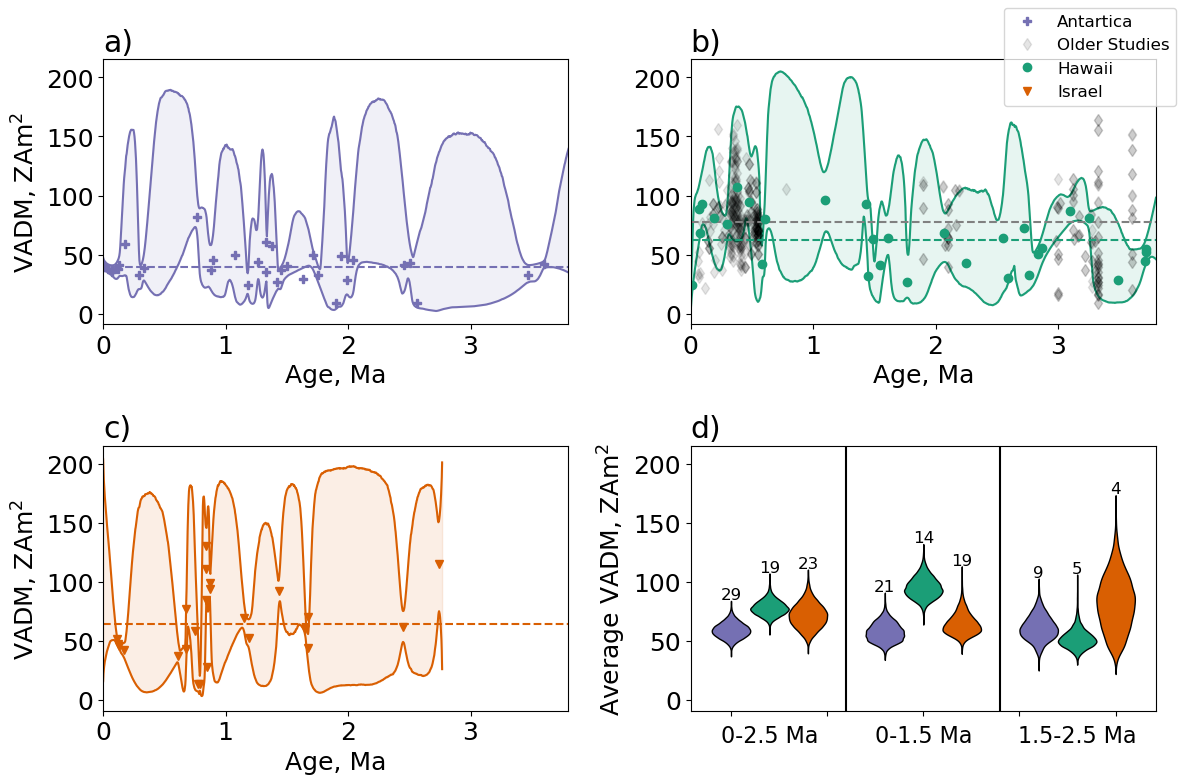

In [8]:
#Plot Figure 8 (Warning, takes some time!)

#Open individual models from each dataset
hawaii_model=open('AH-RJMCMC1/Outputs/models.dat','r').readlines()
golan_model=open('AH-RJMCMC1/Golan/models.dat','r').readlines()
mcmurdo_model=open('AH-RJMCMC1/McMurdo/models.dat','r').readlines()

#Set up figure
fig=plt.figure(figsize=(12,8),layout='constrained')
grid=fig.add_gridspec(4,4)
mcmurdo=fig.add_subplot(grid[0:2,0:2])
hawaii=fig.add_subplot(grid[0:2,2:4])
golan=fig.add_subplot(grid[2:4,0:2])
violins=fig.add_subplot(grid[2:4,2:4])

#Data from Hawaii
lat_bin=all_sites[(all_sites.lat>15)&(all_sites.lat<25)&(all_sites.lon>360-160)&(all_sites.lon<360-155)]
hawaii.plot(lat_bin['age'],pmag.b_vdm(lat_bin['int_abs']*1e6,lat_bin['lat'])/1e27,'kd',alpha=0.1,label='Older Studies');
hawaii.axhline(np.mean(pmag.b_vdm(lat_bin['int_abs']*1e6,lat_bin['lat']))/1e27,color='grey',linestyle='--')
print(np.mean(pmag.b_vdm(lat_bin['int_abs']*1e6,lat_bin['lat']))/1e27)
#Colorblind friendly colors for each plot
colors=['#7570b3','#1b9e77','#d95f02']

#Plot outputs of each model
plot_model_output('AH-RJMCMC1/Golan','Golan.txt',33,golan,colors[2],'v',max_date=3.8,label='Israel')
plot_model_output('AH-RJMCMC1/McMurdo','McMurdo.txt',-78,mcmurdo,colors[0],'P',max_date=3.8,label='Antartica')
plot_model_output('AH-RJMCMC1/Outputs','Hawaii.txt',21,hawaii,colors[1],'o',max_date=3.8,label='Hawaii')

#Plot mean VADMS from 0-1.5 Ma
get_mean_VDMs(golan_model,6,33,violins,colors[2],min_date=0,max_date=1.5,location='Golan Heights')
get_mean_VDMs(hawaii_model,5,21,violins,colors[1],min_date=0,max_date=1.5,location='Hawaiian Islands')
get_mean_VDMs(mcmurdo_model,4,-78,violins,colors[0],min_date=0,max_date=1.5,location='McMurdo')

#Make a line between plots
violins.axvline(3,color='k')

#Plot mean VADMs from 1.5-2.5 Ma
get_mean_VDMs(golan_model,10,33,violins,colors[2],min_date=1.5,max_date=2.5,location='Golan Heights')
get_mean_VDMs(hawaii_model,9,21,violins,colors[1],min_date=1.5,max_date=2.5,location='Hawaiian Islands')
get_mean_VDMs(mcmurdo_model,8,-78,violins,colors[0],min_date=1.5,max_date=2.5,location='McMurdo')

violins.axvline(7,color='k')

#Mean VADMs from 0-2.5 Ma
golan_mean_vdms=get_mean_VDMs(golan_model,2,33,violins,colors[2],min_date=0,max_date=2.5,location='Golan Heights')
hawaii_mean_vdms=get_mean_VDMs(hawaii_model,1,21,violins,colors[1],min_date=0,max_date=2.5,location='Hawaiian Islands')
mcmurdo_mean_vdms=get_mean_VDMs(mcmurdo_model,0,-78,violins,colors[0],min_date=0,max_date=2.5,location='McMurdo')

#violins.axvline(11,color='k')

#Mean VADMs from 0-3.8 Ma.
#get_mean_VDMs(hawaii_model,13,21,violins,colors[1],min_date=0,max_date=3.8,location='Hawaiian Islands')
#get_mean_VDMs(mcmurdo_model,12,-78,violins,colors[0],min_date=0,max_date=3.8,location='McMurdo')


#Add text for each averaging period
violins.text(5,-30,'0-1.5 Ma',ha='center',va='center',fontsize=16)
violins.text(9,-30,'1.5-2.5 Ma',ha='center',va='center',fontsize=16)
violins.text(1,-30,'0-2.5 Ma',ha='center',va='center',fontsize=16)




#Set axes limits and labels.
violins.set_ylabel('Average VADM, ZAm$^2$');
violins.set_ylim(hawaii.get_ylim())
mcmurdo.set_ylim(hawaii.get_ylim())
golan.set_ylim(hawaii.get_ylim())
violins.xaxis.set_ticklabels([])

golan.set_xlim(0,3.8)
hawaii.set_xlim(0,3.8)
mcmurdo.set_xlim(0,3.8)
golan.set_xlabel('Age, Ma')
hawaii.set_xlabel('Age, Ma')
golan.set_ylabel('VADM, ZAm$^2$')
mcmurdo.set_ylabel('VADM, ZAm$^2$')
mcmurdo.set_xlabel('Age, Ma')

mcmurdo.set_title('a)',loc='left')
hawaii.set_title('b)',loc='left')
golan.set_title('c)',loc='left')
violins.set_title('d)',loc='left')

#Save image.
fig.legend(fontsize=12);
plt.tight_layout()
plt.savefig('Figures/Average_VADM.pdf')

### Lowess Model
- This makes code for a Lowess model (nonparametric- different to the AH-RJMCMC model, it's more like a running average.

In [9]:
from statsmodels.nonparametric.smoothers_lowess import lowess
def plot_loess_average(fname,ax,color,marker,lat):
    data=np.loadtxt(fname,dtype='object')
    x=data[:,1].astype('float')/1e3
    y=data[:,3].astype('float')
    y=pmag.b_vdm(y,lat)/1e27
    average=lowess(y,x,xvals=np.linspace(min(x),max(x),100))
    
    ax.scatter(x,y,marker=marker,color=color)
    ax.plot(np.linspace(min(x),max(x),100),average,color=color)


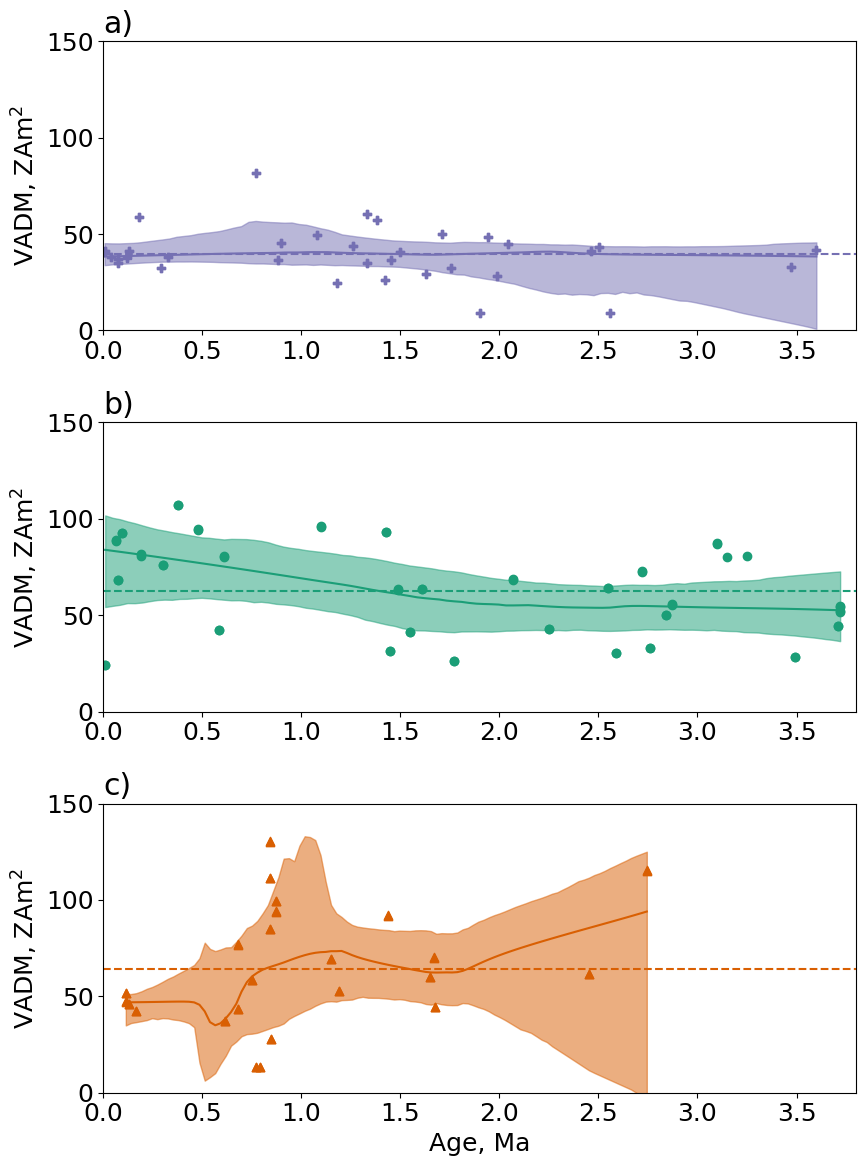

In [10]:
def bootstrap(location,ax,color,marker):
    sites_golan=pd.read_csv('sites.txt',sep='\t',skiprows=1)
    sites_golan=sites_golan[(sites_golan.location==location)&(sites_golan.age<5)]
    sites_golan=sites_golan[sites_golan.method_codes.str.contains('IE-BICEP')].dropna(subset=['age'])
    averages=np.empty((1000,100))
    for i in range(1000):
        choice=np.random.choice(sites_golan.index,len(sites_golan))
        jackknife=sites_golan.loc[choice]
        ages=np.random.normal(jackknife.age,jackknife.age_sigma)
        ints=pmag.b_vdm(np.random.normal((jackknife.int_abs)*1e6,(jackknife.int_abs_max-jackknife.int_abs_min)/4*1e6),jackknife.lat)/1e27
        average=lowess(ints,ages,xvals=np.linspace(np.min(sites_golan.age),np.max(sites_golan.age),100))
        averages[i]=average
    percentiles=np.percentile(averages,(2.5,97.5),axis=0)
    ax.fill_between(np.linspace(np.min(sites_golan.age),np.max(sites_golan.age),100),percentiles[0],percentiles[1],color=color,alpha=0.5,zorder=-1);
    ax.scatter(sites_golan.age,pmag.b_vdm(sites_golan.int_abs*1e6,sites_golan.lat)/1e27,marker=marker,color=color);
    ax.axhline(np.mean(pmag.b_vdm(sites_golan.int_abs*1e6,sites_golan.lat)/1e27),linestyle='--',color=color)

fig,ax=plt.subplots(3,1,figsize=(9,12));

plot_loess_average('AH-RJMCMC1/Outputs/Hawaii.txt',ax[1],colors[1],'o',21)
plot_loess_average('AH-RJMCMC1/McMurdo/McMurdo.txt',ax[0],colors[0],'P',-78)
plot_loess_average('AH-RJMCMC1/Golan/Golan.txt',ax[2],colors[2],'^',33)
bootstrap('McMurdo',ax[0],colors[0],'P')
bootstrap('Hawaiian Islands',ax[1],colors[1],'o')
bootstrap('Golan Heights',ax[2],colors[2],'^');
for a in ax:
    a.set_ylim(0,150)
    a.set_xlim(0,3.8)
    a.set_ylabel('VADM, ZAm$^2$')
plt.xlabel('Age, Ma')
plt.ylabel('VADM, ZAm$^2$')
plt.savefig('Figures/Lowess_Example.pdf')
plt.xlabel('Age, Ma')
ax[0].set_title('a)',loc='left')
ax[1].set_title('b)',loc='left')
ax[2].set_title('c)',loc='left')
plt.tight_layout()
plt.savefig('Bootstrap_Lowess.pdf')

### Ar-Ar plots:
Argon-Argon plots for ages.

In [11]:
ages=pd.read_csv('ages.txt',sep='\t',skiprows=1)
ages_withresults=ages.dropna(subset=['description'])
ages_withresults=ages_withresults[ages_withresults.method_codes=='GM-ARAR-AP']


In [13]:
def get_arar(ax,file,site,age,age_unit):
    arar_dir='Koppers_ArAr_Dir/'
    
    sum_df=pd.read_excel(arar_dir+file,sheet_name='Age Summary',header=2)
    sum_df.dropna(subset=['38Ar\n[fA]','Relative\nAbundances'],inplace=True)
    sum_df=sum_df[['39Ar\n[fA]','Age', '± 2s.1']]
    sum_df.columns=['39Ar_frac','Age','2sigma']

    if age_unit=='ka':
        sum_df['Age']=sum_df['Age']*1e-3
        sum_df['2sigma']=sum_df['2sigma']*1e-3
    sum_df['cum_sum']=sum_df['39Ar_frac'].cumsum()
    sum_df['cum_perc']=100*sum_df['cum_sum']/sum_df['39Ar_frac'].sum()
    sum_df['ages_high']=sum_df['Age']+sum_df['2sigma']
    sum_df['ages_low']=sum_df['Age']-sum_df['2sigma']
    percs=sum_df['cum_perc'].values
    ages_high=sum_df['ages_high'].values
    ages_low=sum_df['ages_low'].values

    for k in range(0,len(percs)-2):

        xs=[percs[k],percs[k+1]]

        ymaxs=[ages_high[k],ages_high[k]]
        ymins=[ages_low[k],ages_low[k]]
        ax.plot(xs,ymaxs,'b-')
        ax.plot(xs,ymins,'b-')
        ax.plot([xs[1],xs[1]],[ages_high[k],ages_high[k+1]],'b-')
        ax.plot([xs[1],xs[1]],[ages_low[k],ages_low[k+1]],'b-')
    plt.text(.1,.9,site+': '+age + ' Ma',transform=ax.transAxes)
    ax.axhline(float(age),linestyle='dotted',color='black',linewidth=2)
    if ages_low.min()<-float(age):
        ymin=-float(age)-.2
    else:
        ymin=ages_low.min()-.4
    if ages_high.max()>10*float(age):
        ymax=10*float(age)
    else:
        ymax=ages_high.max()+.4

    ax.set_ylim(ymin,ymax)
    ax.set_xlim(0,100)
    return sum_df

# of new ages:  21


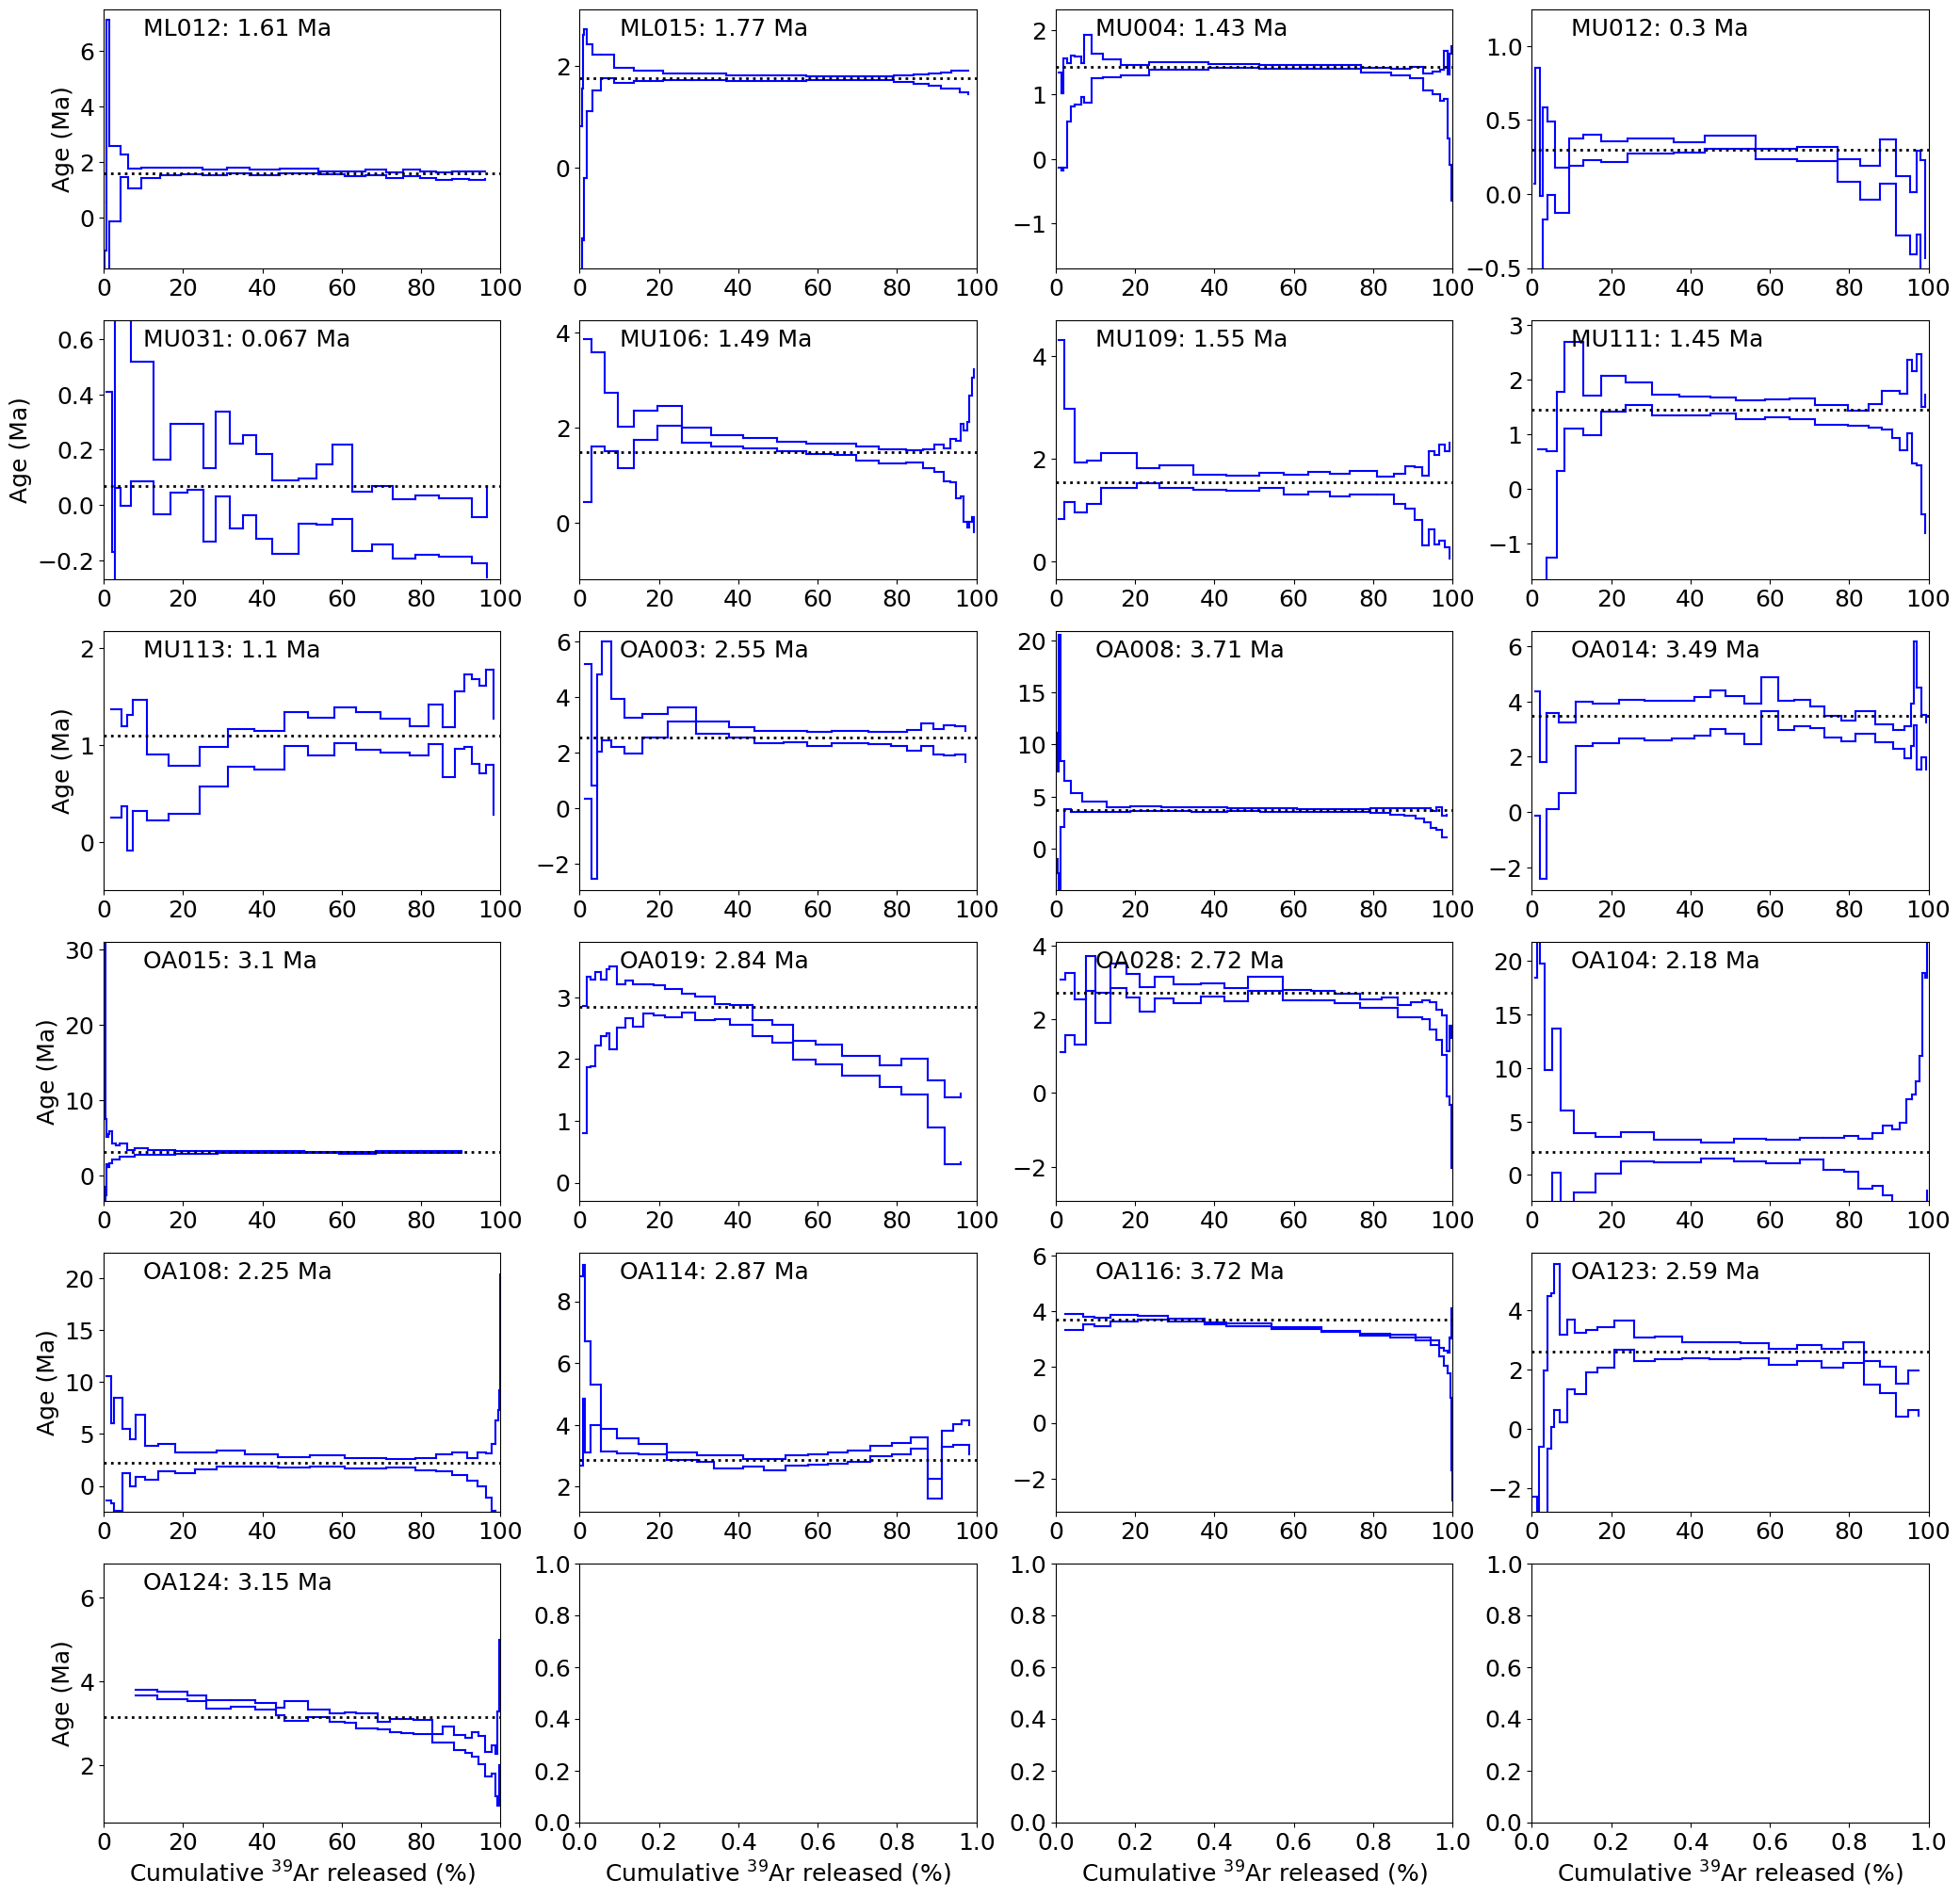

In [14]:
nrows,ncols=6,4
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(25,25))
meta=ages_withresults
meta=meta[meta.site!='OA117']
sites=meta['site'].values

print ('# of new ages: ',len(sites))
row,col=0,0
special=['MU011','MU012','MU031','MU036']# these are in units of Ma, not ka
for site in sites:
    if col>=ncols:
        row+=1
        col=0
    exp_meta=meta[meta['site']==site]
    exp_num=exp_meta['description'].values[0]
    age=str(round(exp_meta['age'].values[0],4))
    file=exp_num+'.full.xls'
    ax=axs[row,col]
    if site not in special:
        sum_df=get_arar(ax,file,site,age,age_unit='Ma')
    else:
        sum_df=get_arar(ax,file,site,age,age_unit='ka')
    if row==nrows-1:
        ax.set_xlabel('Cumulative $^{39}$Ar released (%)')
    if col==0:
        ax.set_ylabel('Age (Ma)')
    col+=1
for ax in axs[-1]:
    ax.set_xlabel('Cumulative $^{39}$Ar released (%)')
plt.savefig('Figures/Ar-Ar.pdf')